In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import scanpy as sc
import plotly.express as px
import plotly.io as pio
import sklearn.preprocessing




torch.autograd.set_detect_anomaly(True)

In [2]:
import platform
if platform.platform() == 'macOS-10.16-x86_64-i386-64bit':
    pio.renderers.default = 'notebook'
    device = torch.device('mps')
    print("Using Apple MPS on Macbook Pro")
    gmount = False
    
elif platform.platform() == 'Linux-5.10.133+-x86_64-with-Ubuntu-18.04-bionic':
    pio.renderers.default = 'colab'
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA GPU on Colab")
        gmount = True

Using Apple MPS on Macbook Pro


In [3]:
scdata = sc.read_h5ad("/Users/eamonmcandrew/Desktop/Single_cell_integration/Data/Multi-ome/GEX.h5ad")

In [4]:
if gmount == True:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/My Drive/Colab Notebooks/Experiments/' 
    scdata = sc.read_h5ad("/content/gdrive/MyDrive/scintegration/GEX.h5ad")

In [5]:
class GEX_Dataset(torch.utils.data.Dataset):
    
      def __init__(self, data,  scaler = None, cat_var = None, label_encoder =None):
          
            self.data = data
            
            # we need to work with the dense matrix
            self.values = data.X.todense()
            
            self.cat_var = cat_var
            
            if label_encoder == "numeric":
            # numerically encode the labels
              cat_var_data =  torch.tensor(sklearn.preprocessing.LabelEncoder().fit_transform(self.data.obs[self.cat_var]), dtype = torch.long)
            
            elif label_encoder == "range_map":
              cat_var_data =  sklearn.preprocessing.LabelEncoder().fit_transform(self.data.obs[self.cat_var])
              cat_var_data = cat_var_data.reshape(-1, 1) 
              cat_var_data = torch.tensor(sklearn.preprocessing.MinMaxScaler().fit_transform(cat_var_data), dtype = torch.float32)

            elif label_encoder == "one_hot":
              cat_var_data =  torch.tensor(sklearn.preprocessing.LabelEncoder().fit_transform(self.data.obs[self.cat_var]))
              cat_var_data = cat_var_data.reshape(-1, 1)
              cat_var_data = sklearn.preprocessing.OneHotEncoder().fit_transform(cat_var_data).toarray()
              cat_var_data = torch.tensor(cat_var_data, dtype=torch.float32)
              



            self.cat_var_data = torch.tensor(cat_var_data)
            
            # scale the data according to user inpt to scaler argument
            if scaler == "Standard":
                self.scaled_values = torch.tensor(sklearn.preprocessing.StandardScaler().fit_transform(self.values), dtype = torch.float32)
            elif scaler == "MinMax":
                self.scaled_values = torch.tensor(sklearn.preprocessing.MinMaxScaler().fit_transform(self.values),  dtype = torch.float32)
            else:
                self.scaled_values = torch.tensor(self.values, dtype = torch.float32)
                
    #   return the number of genes when called 
             
      @property
      def n_features(self):
          return self.values.shape[1]

      @property
      def n_catagories(self):
          return self.cat_var_data.shape[1]
        
      
          
          
    #  A dataset class needs the following two methods to work with the dataloader class     
          
    #   return the number of cells when called
      def __len__(self):
          return len(self.data)
    
    #  return an individual cell and its label when called
      def __getitem__(self, idx):
           return self.scaled_values[idx], self.cat_var_data[idx]

    

In [6]:
GEX_Dataset = GEX_Dataset(scdata, scaler = "Standard", cat_var = "batch", label_encoder = "one_hot")


/var/folders/mw/_f0gy0f54t739qb79y8cxb_40000gn/T/ipykernel_5920/612472411.py:30: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/Users/eamonmcandrew/opt/anaconda3/envs/scINTEGRATION/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

/Users/eamonmcandrew/opt/anaconda3/envs/scINTEGRATION/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



In [7]:
input_size = GEX_Dataset.n_features
output_size = GEX_Dataset.n_catagories


batch_size = 256
epochs = 100
lr = 1e-3

log_interval = 10

In [8]:
output_size


13

In [9]:
class classifier(nn.Module):
    def __init__(self):
        super(classifier, self).__init__()
        self.cfc1 = nn.Linear(input_size, 20)
        self.dropout = nn.Dropout(0.25)
        self.cfc2 = nn.Linear(20, output_size)
        
    def forward(self, x):
        x = self.cfc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.cfc2(x)
        x = F.softmax(x, dim = 1)
        return(x)

In [10]:
GEX_dataloader = DataLoader(GEX_Dataset, batch_size=batch_size, shuffle=True)
model = classifier()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
model.train()

criterion = nn.CrossEntropyLoss()

In [11]:
loss_list = []
accuracy_list = []
mean_loss = 0
mean_accuracy =0

for epoch in range(epochs+1):
    for batch_idx, (data, target) in enumerate(GEX_dataloader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        loss_list.append(loss.item())
        optimizer.step()
        accuracy_list.append((output.argmax(1) == target.argmax(1)).type(torch.float).mean().item())
        if batch_idx % log_interval == 0:
            print(f"Train Epoch {epoch} [{batch_idx * len(data)}/{len(GEX_dataloader.dataset)} ({100. * batch_idx / len(GEX_dataloader):.0f}%)]\tLoss: {loss.item():.6f}, mean accuracy last epoch: {np.mean(accuracy_list[mean_accuracy:]):.3f}")
mean_loss = np.mean(loss_list)
mean_accuracy = np.mean(accuracy_list)
print(f"Epoch: {epoch}, Mean Loss: {mean_loss:.6f}, Mean Accuracy: {mean_accuracy:.6f}, Training {100. * epoch / epochs}% Complete")


Train Epoch 0 [0/69249 (0%)]	Loss: 2.566708, mean accuracy last epoch: 0.047
Train Epoch 0 [2560/69249 (4%)]	Loss: 2.421740, mean accuracy last epoch: 0.246
Train Epoch 0 [5120/69249 (7%)]	Loss: 2.362178, mean accuracy last epoch: 0.286
Train Epoch 0 [7680/69249 (11%)]	Loss: 2.259942, mean accuracy last epoch: 0.323
Train Epoch 0 [10240/69249 (15%)]	Loss: 2.269328, mean accuracy last epoch: 0.348
Train Epoch 0 [12800/69249 (18%)]	Loss: 2.272182, mean accuracy last epoch: 0.370
Train Epoch 0 [15360/69249 (22%)]	Loss: 2.215322, mean accuracy last epoch: 0.390
Train Epoch 0 [17920/69249 (26%)]	Loss: 2.266950, mean accuracy last epoch: 0.405
Train Epoch 0 [20480/69249 (30%)]	Loss: 2.176337, mean accuracy last epoch: 0.421
Train Epoch 0 [23040/69249 (33%)]	Loss: 2.117740, mean accuracy last epoch: 0.434
Train Epoch 0 [25600/69249 (37%)]	Loss: 2.205539, mean accuracy last epoch: 0.443
Train Epoch 0 [28160/69249 (41%)]	Loss: 2.135025, mean accuracy last epoch: 0.454
Train Epoch 0 [30720/69249

In [12]:
# I am trying to train a classifier on a dataset of cells with a single label. I am using the pytorch dataloader class to load the data into the model. I am using the following code to train the model:

In [13]:
model.eval()

classifier(
  (cfc1): Linear(in_features=13431, out_features=20, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (cfc2): Linear(in_features=20, out_features=13, bias=True)
)

In [14]:
for batch_idx, (data, target) in enumerate(GEX_dataloader):
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    loss = criterion(output, target)
    print(f"Target {target[:1]}, Output {output[:1]}, Loss {loss.item()}")


Target tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], device='mps:0'), Output tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5648e-17,
         0.0000e+00]], device='mps:0', grad_fn=<SliceBackward0>), Loss 1.887972116470337


/Users/eamonmcandrew/opt/anaconda3/envs/scINTEGRATION/lib/python3.9/site-packages/torch/_tensor_str.py:103: UserWarning:

The operator 'aten::bitwise_and.Tensor_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1664817783366/work/aten/src/ATen/mps/MPSFallback.mm:11.)



Target tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], device='mps:0'), Output tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], device='mps:0',
       grad_fn=<SliceBackward0>), Loss 1.8449829816818237
Target tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='mps:0'), Output tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 6.6840e-12, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00]], device='mps:0', grad_fn=<SliceBackward0>), Loss 1.8838504552841187
Target tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='mps:0'), Output tensor([[1.8239e-10, 4.9540e-27, 4.2470e-24, 1.0000e+00, 8.1389e-07, 2.2309e-22,
         3.6701e-21, 1.4629e-32, 8.9866e-26, 0.0000e+00, 0.0000e+00, 1.0769e-34,
         4.6025e-37]], device='mps:0', grad_fn=<SliceBackward0>), Loss 1.856528878211975
Target tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], device='

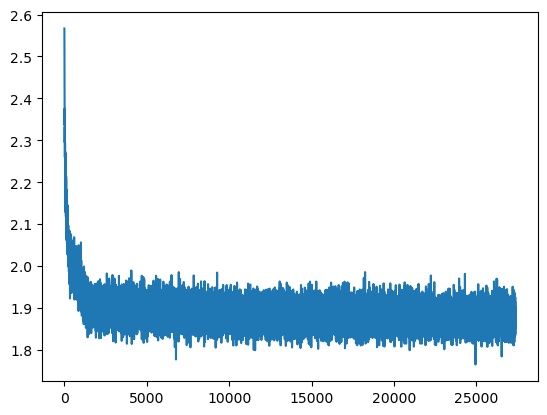

In [15]:
# visualise the loss

plt.plot(loss_list)

In [16]:
def predict(model, data):
    model.eval()
    with torch.no_grad():
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
    return pred
        
        


In [17]:
def get_total_accuracy(model, data_loader):
    accuracy_total = []
    for batch_idx, (data, target) in enumerate(data_loader):
        data = data.to(device)
        target = target.to(device)
        pred = predict(model, data).cpu()
        actual = target.argmax(dim=1, keepdim=True).cpu()
        accuracy_total.append(pred.eq(actual).sum().item() / len(pred))
    return np.mean(accuracy_total)
    


In [18]:
get_total_accuracy(model, GEX_dataloader)

0.8206059240824966

In [19]:
# scdata = sc.read_h5ad("/Users/eamonmcandrew/Desktop/Single_cell_integration/Data/Multi-ome/GEX.h5ad")
# cell_data = pd.DataFrame(scdata.X.todense().T)
# cell_cell_corr = pd.DataFrame(np.corrcoef(cell_data.values, rowvar=False), columns=cell_data.columns)

In [20]:
# cell_cell_corr = cell_cell_corr.where(np.triu(np.ones(cell_cell_corr.shape), k=1).astype(np.bool))

In [21]:
grad_cam(model, GEX_dataloader)

NameError: name 'grad_cam' is not defined